In [131]:
import pandas as pd
import requests
import warnings
warnings.filterwarnings("ignore")

## Data collection

Se realiza la lectura de los objetos directamente desde el github de felipeares.

In [2]:
url = 'https://raw.githubusercontent.com/felipeares/legalbot-desafio-objetos/master/objetos.txt'
page = requests.get(url)
#Se identificó visualmente que el separador de los objetos corresponde a los caracteres \n\n
df_corpus = pd.DataFrame(page.text.split('\n\n'), columns = ['objeto'])

In [3]:
df_corpus.head()

,objeto
0,"CONSTRUCCIÓN, ALQUILER DE OTROS TIPOS DE MAQUI..."
1,el servicio de turismo por todo el territorio ...
2,SALON DE BELLEZA.
3,"CURSOS ONLINE DE MUSICA, COCINA, CLASES DE MUS..."
4,"el ejercicio de la actividad comercial,importa..."


## Data Preprocessing

In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jota\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jota\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jota\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
import string  #Se obtendrá los signos de puntuación
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, SnowballStemmer

In [310]:
#Método limpieza inicial y tokenización
def get_tokens_clean(objeto):
    #Se deja el texto en minúscula
    objeto = objeto.lower()
    
    #Elimina tildes
    a,b = 'áéíóúü','aeiouu',
    trans = str.maketrans(a,b)
    objeto = objeto.translate(trans)
    
    #Elimina caracteres que no sean palabras
    #En esta instancia se reemplazan los signos de puntuación por un espacio, ya que en algunos parragos
    # hay palabras con puntuaciones sin espacios. Ejemplo : producto,comercial.
    filtered_punctuation =  objeto.translate({ord(c): ' ' for c in string.punctuation}).replace('  ',' ')
    
    #tokeniza
    tokens = nltk.word_tokenize(filtered_punctuation)
    
    #Se eliminan stopwords (articulos, preposiciones, etc.)
    no_stopwords = [word for word in tokens if word not in stopwords.words('spanish')]
       
    return no_stopwords

#Función de derivacion 
def stem_words(tokens):
    stemmer_spanish = SnowballStemmer('spanish')
    stems = []
    for word in tokens:
        stem = stemmer_spanish.stem(word)
        stems.append(stem)
    return stems

#Elimina palabas menor a tres caracteres
def delete_characteres(tokens):
    return  [word for word in tokens if len(word)>3]

#Lematización de verbos. Por ahora sólo palabras en inglés.
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')


In [8]:
from gensim.corpora import Dictionary

df_corpus['objeto_tokens'] = df_corpus['objeto'].map(get_tokens_clean)
df_corpus['objeto_tokens'] = df_corpus['objeto_tokens'].map(delete_characteres) 
df_corpus['objeto_stemm']  = df_corpus['objeto_tokens'].map(stem_words)
#df_corpus['objeto_stemm']  = df_corpus['objeto_stemm'].map(replace_word_frequence)

## Data exploration

Gráfico con las palabras más frecuentes del corpus

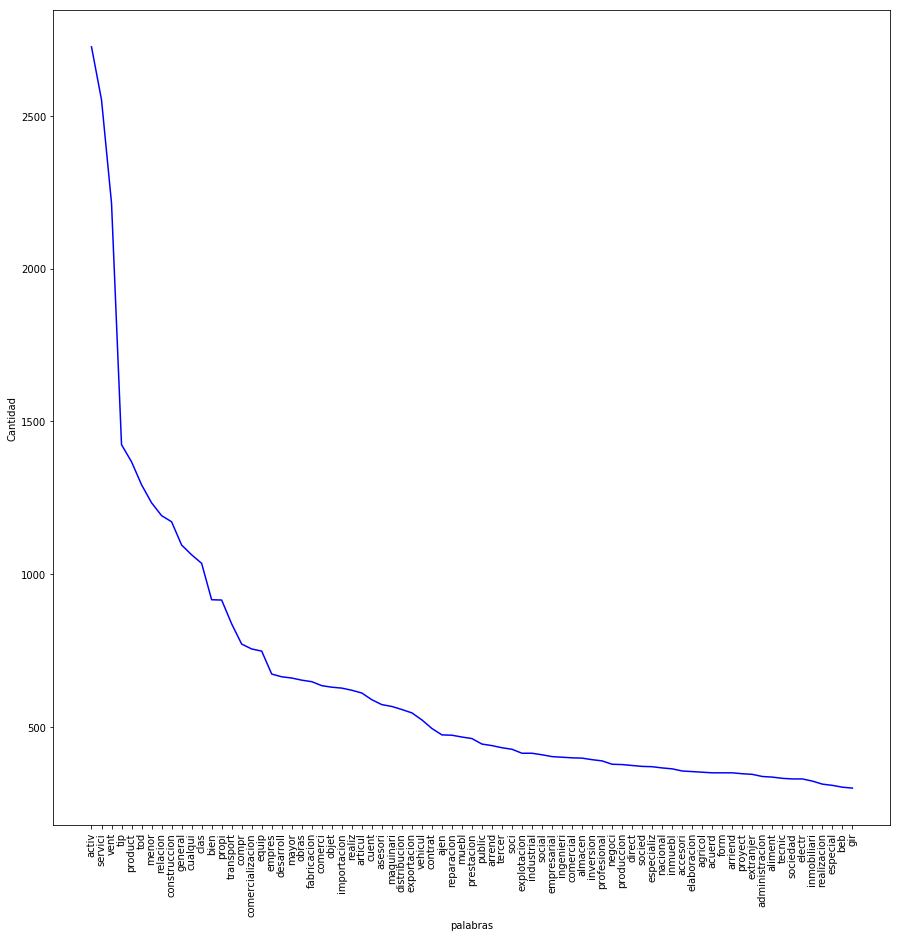

In [12]:
import matplotlib.pyplot as plt
words_unique = [word for idx,array_word in df_corpus.iterrows() for word in array_word['objeto_stemm']]
word_group = pd.DataFrame(words_unique,index=words_unique,columns=['word'])['word']
word_group_count = word_group.value_counts()
plt.figure(figsize=(15, 15))
plt.ion()

plt.plot(word_group_count[word_group_count>300], 'b')  # Dibujamos una línea recta azul
plt.xlabel('palabras')  # Ponemos etiqueta al eje x
plt.ylabel(u'Cantidad')  # Ponemos etiqueta al eje y
plt.xticks(rotation=90)
plt.show()

Se genera un vector de la cantidad de veces que aparece cada palabra en el documento

In [13]:
flat_list = [word for tokens in df_corpus['objeto_stemm'].tolist() for word in tokens]
word_group = pd.DataFrame(flat_list,index=flat_list,columns=['word'])['word']
word_group_count = word_group.value_counts()
#word_group_count

Se eliminan palabras con alta frecuencia, ya que entrega poca importancia al momento de generar los tópicos.
Arbitrariamente, se elige el valor máximo de la frecuencia de la palabra (1000)

In [14]:
def delete_words_frequence(tokens):
    return [word for word in tokens if word not in word_group_count[word_group_count<10]]

In [15]:
df_corpus['no_frequence_words'] = df_corpus['objeto_stemm'].map(delete_words_frequence)

## Create dictionary

In [17]:
#Se crea diccionario
dct = Dictionary(df_corpus['no_frequence_words'].tolist())

In [29]:
list_words = list([x for x in dct.itervalues()])

print('Total palabras en el diccionario : {}'.format(len(list_words)))

Total palabras en el diccionario : 1049


## Bag of Words on the Data set

Representa el texto como una bolsa de palabras y su frecuencia de aparición, sin tener en cuenta gramática ni orden de palabras

In [31]:
from gensim import corpora, models

df_corpus['bow']   = df_corpus['no_frequence_words'].map(dct.doc2bow)
corpus_bow = df_corpus['bow'].tolist()

El siguiente resultado muestra un diccionario : palabra => vector 2D

In [64]:
example_word_bow = [tupl for indx, row in df_corpus.sample(1).iterrows() for tupl in (row['objeto_stemm'],row['bow'])]
example_word_bow

[['servici', 'informat'], [(78, 1), (179, 1)]]

## TF-IDF

TF = (Número de veces que la palabra clave aparece en el documento) / (Número total de palabras en el documento).

IDF = (Número total de documentos) / (Número total de términos en el documento)

representa cómo de importante es una palabra en un documento dentro de un conjunto de documentos. El valor tf-idf aumenta proporcionalmente al número de veces que una palabra aparece en el documento, pero es compensada por la frecuencia de la palabra dentro del conjunto de documentos. De esta manera, se gestiona el hecho de que algunas palabras son más comunes que otras.

In [65]:
model_tfidf = models.TfidfModel(corpus_bow)
df_corpus['tf_idf'] = model_tfidf[df_corpus.bow.tolist()]
corpus_tfidf = df_corpus['tf_idf'].tolist()

El siguiente resultado muestra un diccionario para tf-idf : palabra => vector

In [70]:
example_word_tf_idf = [tupl for indx, row in df_corpus.sample(1).iterrows() for tupl in (row['objeto_stemm'],row['tf_idf'])]
example_word_tf_idf

[['hotel', 'campament', 'tip', 'hospedaj', 'temporal'],
 [(10, 0.19038269584200554),
  (44, 0.4816922829402948),
  (310, 0.46343493434276734),
  (373, 0.5157648662587536),
  (397, 0.5009407530272441)]]

## LDA 

extensión de pLSA, y a diferencia de la familia de modelos LSI, es un modelo generativo que representa los documentos como una mezcla de topics formados por palabras con una probabilidad (que se parece más a lo que es un documento real). Esto hace que LDA sea el método más común para extraer topics (topic modeling). Esto es, cada documento tendrá asociado n topics con una probabilidad. LDA descubre automáticamente estos topics, los cuales siguen una distribución Dirichlet. La parte de latente viene en este caso porque en estadística, una variable que hay que inferir en vez de observar se llama variable latente. En nuestro caso, observamos las palabras y no los temas, con lo que nuestras variables latentes son los temas.

#### Running LDA using Bag of Words

In [103]:
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

In [260]:
ldabow_model_path = "embedding/lda_model_bow"

def run_lda_bow(topic_number):
    lda_model_path = ldabow_model_path
    lda_model = models.LdaModel(corpus_bow, num_topics=topic_number, id2word=dct, passes=5, iterations=500)
    df_corpus['lda'] = lda_model[df_corpus.bow.tolist()]
    lda_model.save(lda_model_path)
    return lda_model    

#### Running LDA using TF-IDF

In [261]:
ldatfidf_model_path = "embedding/lda_model_tfidf"

def run_lda_tfidf(topic_number):
    lda_model_path = ldatfidf_model_path
    lda_model = models.LdaMulticore(corpus_tfidf, num_topics=topic_number, id2word=dct, passes=5, workers=4)
    #df_corpus['lda_tfidf'] = lda_model[df_corpus.tf_idf.tolist()]
    lda_model.save(lda_model_path)
    return lda_model    

## Optimization number of topics

Para poder obtener un número óptimo de tópicos, es necesarios generar distintos modelos LDA y elegir aquel que entregue el mayor número de coherencia (c_v)^5 más grande considerando el contexto.

In [106]:
from time import time
def compute_coherence_values(dictionary, corpus, texts, start, limit):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit):
        start_time = time()
        model=models.LdaModel(corpus=corpus          #Corpus
                            , id2word=dictionary     #Diccionario
                            , num_topics=num_topics  #Número de tópicos
                            , passes=5               #Cuántas veces se supone que el algoritmo pasa sobre todo el corpus
                            , iterations=500         #Se establece un limite para la convergencia
                            )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        elapsed_time = time() - start_time
        coherence_values.append((num_topics,coherencemodel.get_coherence(),round(elapsed_time,2)))
        print('Numero de topicos : {}, valor coherencia : {}'.format(num_topics,coherencemodel.get_coherence()))
    return model_list, coherence_values

## Visualización

Mediante el package pyLDAvis, podemos visualizar los grupos que se han formado. Analizar sus tamaños, la distancia entre ellos o su solapamiento. En conjunto con la frecuencia de las palabras que pertenecen a cada grupo.

In [118]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()


def visualization_topics(model,corpus,name_html='test_topicos'):
    LDAvis_prepared = pyLDAvis.gensim.prepare(model, corpus, dct)
    pyLDAvis.save_html(LDAvis_prepared,name_html+str('.html'))
    #pyLDAvis.show(LDAvis_prepared)
    #pyLDAvis.display()

import matplotlib.pyplot as plt

def plt_topics_coherence(lista):
    x_val = [x[0] for x in lista]
    y_val = [x[1] for x in lista]
        
    plt.figure(figsize=(15, 15))
    plt.ion()
    plt.ylim(0,1)
    plt.plot(x_val,y_val)
    plt.plot(x_val,y_val,'or')
    plt.title('Valor coherencia por tópicos')
    plt.xlabel('Tópicos')  # Ponemos etiqueta al eje x
    plt.ylabel(u'Value coherence')  # Ponemos etiqueta al eje y
    plt.show()

def plt_topics_time(lista):
    x_val = [x[0] for x in lista]
    y_val = [x[2] for x in lista]
        
    plt.figure(figsize=(15, 15))
    plt.ion()
    plt.ylim(0,max(y_val)+10)
    plt.plot(x_val,y_val)
    plt.plot(x_val,y_val,'or')
    plt.title('Tiempo de ejecución por número de tópicos')
    plt.xlabel('Tópicos')  # Ponemos etiqueta al eje x
    plt.ylabel(u'Tiempo ejecución (s)')  # Ponemos etiqueta al eje y
    plt.show()

## Call metodos LDA y optimización de k-tópicos

Ejecución de modelos con distintos numeros de tópicos. Éstos serán evaluados según su valor de coherencia.- TFIDF

In [120]:
models_tfidf, list_topics_coherence_tfidf = compute_coherence_values(dct,corpus_tfidf,df_corpus['no_frequence_words'],4,5)

Numero de topicos : 4, valor coherencia : 0.490476410667096


Gráfico tópicos vs valor de coherencia

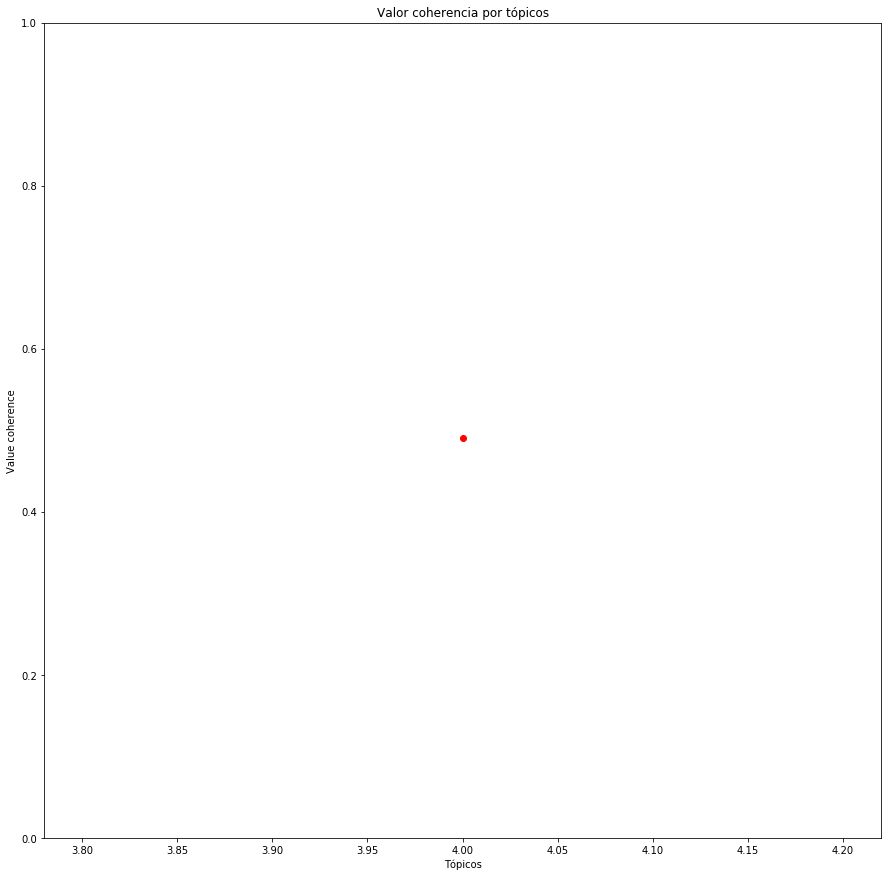

In [126]:
plt_topics_coherence(list_topics_coherence_tfidf)

Mediante la respuesta del gráfico anterior, podemos discriminar y elegir el número K conveniente para ejecutar.


Gráfico tiempo de ejecución de tópicos 

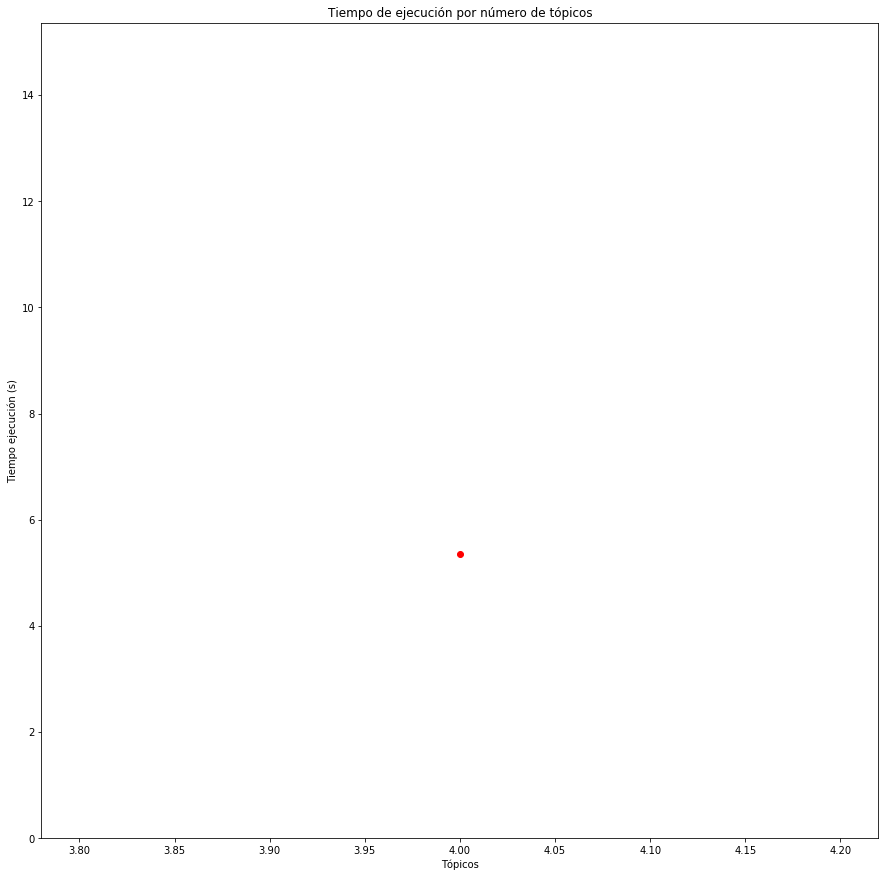

In [127]:
plt_topics_time(list_topics_coherence_tfidf)

In [296]:
number_topics = 12 
lda_model_tfidf    =  run_lda_tfidf(number_topics)
topics_model_tfidf = lda_model_tfidf.print_topics(-1)
for idx, topic in topics_model_tfidf:
    print('Topic: {} Palabras: {} \n'.format(idx, topic))
visualization_topics(lda_model_tfidf,corpus_tfidf,'topics_tfidf')

Topic: 0 Palabras: 0.036*"empresarial" + 0.029*"activ" + 0.027*"profesional" + 0.023*"prest" + 0.018*"empres" + 0.017*"alquil" + 0.016*"equip" + 0.016*"fabricacion" + 0.016*"servici" + 0.015*"maquinari" 

Topic: 1 Palabras: 0.109*"construccion" + 0.051*"servici" + 0.049*"activ" + 0.044*"obras" + 0.030*"menor" + 0.028*"ingenieri" + 0.023*"arquitectur" + 0.020*"tecnic" + 0.016*"vent" + 0.013*"articul" 

Topic: 2 Palabras: 0.031*"product" + 0.025*"elaboracion" + 0.024*"alimentici" + 0.017*"telecomun" + 0.017*"vent" + 0.016*"comercializacion" + 0.015*"informat" + 0.013*"servici" + 0.011*"distribuidor" + 0.010*"mayor" 

Topic: 3 Palabras: 0.029*"vent" + 0.029*"aliment" + 0.029*"product" + 0.026*"mayor" + 0.024*"restaur" + 0.023*"bar" + 0.023*"terrestr" + 0.021*"transport" + 0.021*"beb" + 0.020*"cantin" 

Topic: 4 Palabras: 0.027*"inmobiliari" + 0.021*"realiz" + 0.019*"contrat" + 0.018*"articul" + 0.017*"construccion" + 0.015*"arrend" + 0.015*"vent" + 0.015*"menor" + 0.014*"activ" + 0.014*"c

Ejecución de modelos con distintos numeros de tópicos. Éstos serán evaluados según su valor de coherencia.- BOW

In [122]:
models_bow, list_topics_coherence_bow = compute_coherence_values(dct,corpus_bow,df_corpus['no_frequence_words'],4,5)

Numero de topicos : 4, valor coherencia : 0.5362604248447229


Gráfico tópicos vs valor de coherencia - bow 

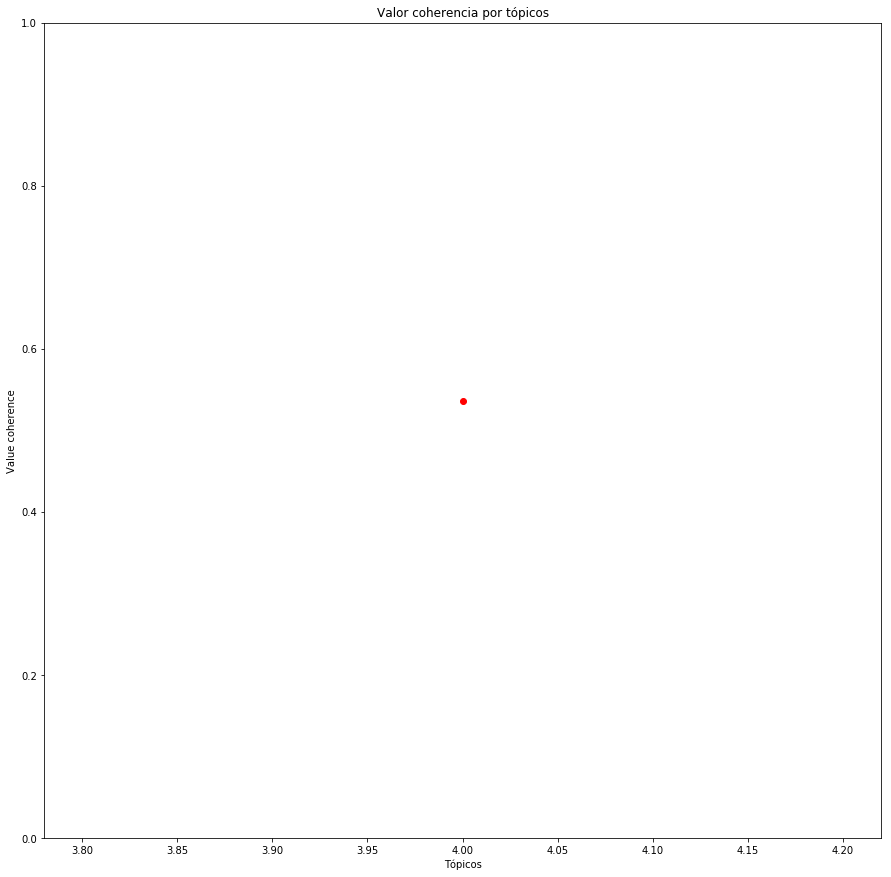

In [124]:
plt_topics_coherence(list_topics_coherence_bow)

Gráfico tiempo de ejecución de tópicos - bow

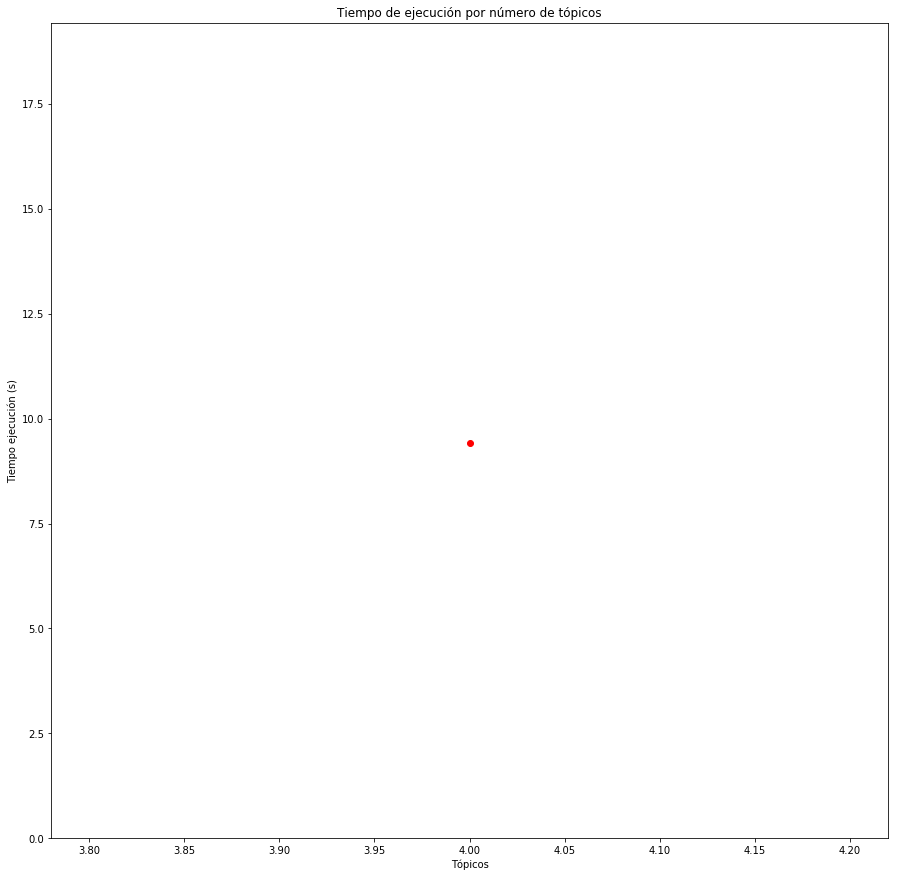

In [125]:
plt_topics_time(list_topics_coherence_bow)

In [291]:
number_topics = 11
lda_model_bow    =  run_lda_bow(number_topics)
visualization_topics(lda_model_bow,corpus_bow,'topics_bow')
topics_model_bow = lda_model_bow.print_topics(-1)
for idx, topic in topics_model_bow:
    print('Topic: {} Palabra: {} \n'.format(idx, topic))

Topic: 0 Palabra: 0.072*"vent" + 0.054*"articul" + 0.044*"importacion" + 0.038*"product" + 0.036*"compr" + 0.035*"exportacion" + 0.028*"comercializacion" + 0.025*"accesori" + 0.020*"prend" + 0.020*"vest" 

Topic: 1 Palabra: 0.082*"construccion" + 0.057*"obras" + 0.026*"menor" + 0.017*"contrat" + 0.017*"ingenieri" + 0.017*"equip" + 0.017*"general" + 0.015*"servici" + 0.014*"edifici" + 0.014*"civil" 

Topic: 2 Palabra: 0.028*"tod" + 0.025*"clas" + 0.022*"cualqui" + 0.020*"bien" + 0.019*"tip" + 0.017*"propi" + 0.016*"relacion" + 0.014*"activ" + 0.014*"cuent" + 0.013*"objet" 

Topic: 3 Palabra: 0.065*"articul" + 0.040*"vent" + 0.031*"comercializ" + 0.028*"import" + 0.023*"clas" + 0.022*"deriv" + 0.020*"export" + 0.019*"product" + 0.019*"tod" + 0.018*"compr" 

Topic: 4 Palabra: 0.057*"transport" + 0.056*"vehicul" + 0.033*"vent" + 0.032*"reparacion" + 0.030*"servici" + 0.026*"activ" + 0.025*"automotor" + 0.021*"fabricacion" + 0.020*"maquinari" + 0.019*"carg" 

Topic: 5 Palabra: 0.130*"menor"

## Predict 

A continuación se genera la función para poder predecir a qué tópico corresponde un parráfo.

In [308]:
from gensim.models import LdaModel

def predict_tfidf(text):
    lda = LdaModel.load(ldatfidf_model_path)
    text_tokens = get_tokens_clean(text)
    text_delete_no_words = delete_characteres(text_tokens)
    text_stemm = stem_words(text_delete_no_words)
    text_bow = dct.doc2bow(text_stemm)
    new_review_lda = model_tfidf[text_bow]
    new_review_lda = lda_model_tfidf[new_review_lda]
    return max(new_review_lda,key=lambda item:item[1])


def predict_bow(text):
    lda = LdaModel.load(ldabow_model_path)
    text_tokens = get_tokens_clean(text)
    text_delete_no_words = delete_characteres(text_tokens)
    text_stemm = stem_words(text_delete_no_words)
    text_bow = dct.doc2bow(text_stemm)
    new_review_lda = lda_model_bow[text_bow]
    return max(new_review_lda,key=lambda item:item[1])

Predicción mediante lda transformando palabras al espacio numerico **bow**

In [295]:
predict_text = predict_bow('actividades servicios peluqueria fabrica')
print('Grupo al que corresponde : {} y su probabilidad : {}\n'.format(predict_text[0],predict_text[1]))

print('Tópico perteneciente : {}'.format(topics_model_bow[predict_text[0]][1]))

Grupo al que corresponde : 9 y su probabilidad : 0.39849627017974854

Tópico perteneciente : 0.127*"activ" + 0.086*"servici" + 0.040*"empresarial" + 0.035*"profesional" + 0.028*"empres" + 0.022*"asesori" + 0.020*"inmobiliari" + 0.020*"realiz" + 0.019*"prest" + 0.019*"tecnic"


Predicción mediante lda transformando palabras al espacio numerico **tf-idf**

In [309]:
predict_text = predict_tfidf('actividades servicios peluqueria fabrica')
print('Grupo al que corresponde : {} y su probabilidad : {}\n'.format(predict_text[0],predict_text[1]))

print('Tópico perteneciente : {}'.format(topics_model_tfidf[predict_text[0]][1]))

Grupo al que corresponde : 7 y su probabilidad : 0.6592296361923218

Tópico perteneciente : 0.043*"carg" + 0.036*"transport" + 0.036*"carreter" + 0.016*"informat" + 0.016*"comercializ" + 0.013*"product" + 0.012*"peluqueri" + 0.012*"prend" + 0.012*"fabricacion" + 0.012*"bellez"


# Conclusiones

El desafio consiste en poder generar un modelo, para poder agrupar algún párrafo asociado al contexto de "Objeto de una sociedad es el párrafo que da cuenta de las actividades a las cuales se dedicará la recién creada empresa".

En un principio se realizan múltiples limpiezas, eliminación de signos de puntuacion como por ej.: .,!?(.. etc, convertir el texto en minuscula para normalizar. Se eliminan stopwords y se tokeniza. Posteriormente eliminamos palabras que contengan menos de 3 caracteres ya que  generalmente son palabras que entregan poca información y finalmente se obtiene su palabra derivada.
En este último punto, sería conveniente reforzar la extracción de la palabra derivada ya que en veces corta palabras de forma distinta cuando hacen referencia al mismo contexto, por ej. empresa = empres; empresarial = empresarial.

Posteriormente. se transforma el token ya limpio a un espacio númerico o también dicho a un diccionario, donde cada palabra está representada por un número. A esto se le denomina que se encuentran en una bolsa de palabras (bow). Esto es necesario, ya que al momento de generar tópicos se pueden obtener distancias entre ellos. 

En el paso siguiente, se transforma los valores de bow a TF-IDF, que cómo se explicó, obtiene básicamente la importancia de una palabra en los distintos documentos o en el documento en este contexto.

Acá se trabajó con un dataframe que contienen los valores de la cadena real, el tokens, bow y tfidf para poder aplicar LDA el cual busca relaciones de palabras mediante la distribucion  Latent Dirichlet Allocation, para grupos no observados o aplicación de aprendizaje no supervisado. mediante vectores latentes.

Se realizan dos modelos principales, mediante datos de entrenamiento bow y tfidf y sus respectivas visualizaciones.

# Trabajo futuro a mejorar

Además de haber utilizado lda como modelo no supervisado. También es muy utilizado el modelo K-medias. En los siguientes bloques se crea un modelo k-means mediante el package sklearn. En el cuál no generan buenos centroides, incluso, al gráficar se puede visualizar que existen pésimas agrupaciones, lo cual no puede definir con claridad a qué grupo pertenece.
Además, tampoco se pudo definir el "nombre" de cada uno de los cluster.Por lo mismo queda como trabajo futuro.

## K-Means

Es un método de agrupacion que se basa en las distancias existentes entre ellos en un conjunto de variables.En este contexto, se generará una distancia euclidina entre los valores obtenidos previamente de tf-idf

In [259]:
from sklearn.cluster import KMeans

In [247]:
def convert_tfidf(text):
    text_tokens = get_tokens_clean(text)
    text_delete_no_words = delete_characteres(text_tokens)
    text_stemm = stem_words(text_delete_no_words)
    text_bow = dct.doc2bow(text_stemm)
    text_tfidf = model_tfidf[text_bow]
    return text_tfidf

from statistics import mode

def predict_kmeans(text):
    text_tfidf = convert_tfidf(text)
    array_kmeans = kmeans.predict(text_tfidf)
    return mode(array_kmeans)


In [248]:
k_cluster = 5
flatten_tfidf = [v_tfidf for x in df_corpus['tf_idf'] for v_tfidf in x]
kmeans = KMeans(n_clusters=k_cluster).fit(flatten_tfidf)

In [251]:
print('Cluster al que pertenece el párrafo : {}'.format(predict_kmeans('venta de ropa productos servicios peluqueria tijeras')))

Cluster al que pertenece el párrafo : 1


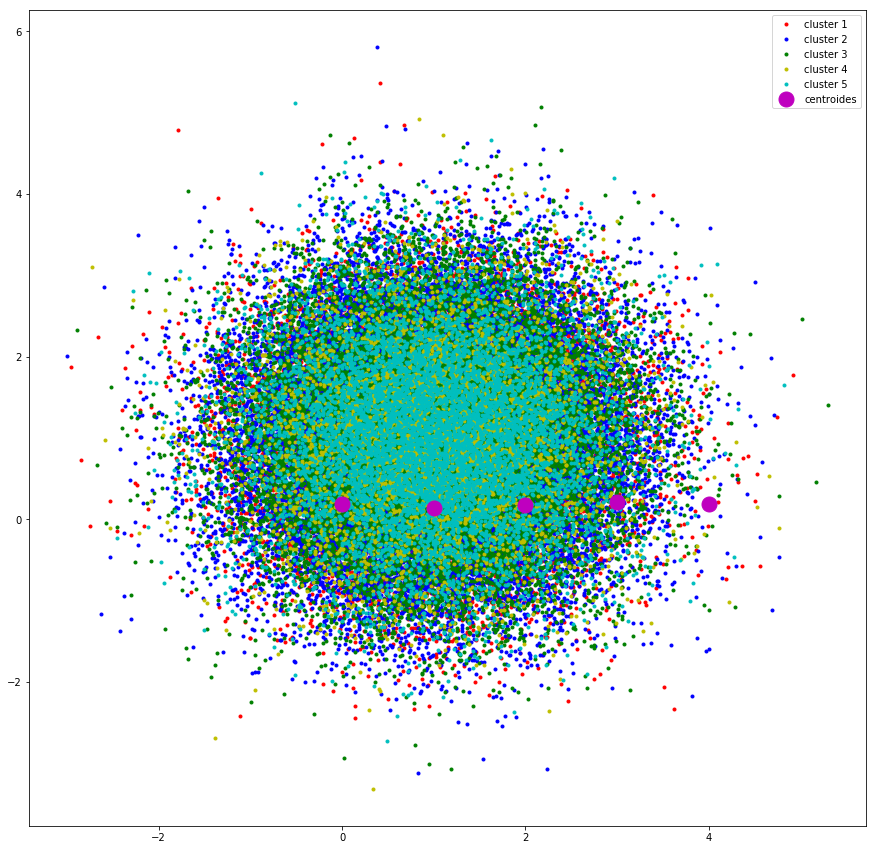

In [258]:
import numpy as np
centroides = kmeans.cluster_centers_
etiquetas = kmeans.labels_

np.random.seed(7)

X = np.random.standard_normal((len(etiquetas),2))+np.ones((len(etiquetas),2))

plt.figure(figsize=(15, 15))
plt.ion()
plt.plot(X[etiquetas==0,0],X[etiquetas==0,1],'r.', label='cluster 1')
plt.plot(X[etiquetas==1,0],X[etiquetas==1,1],'b.', label='cluster 2')
plt.plot(X[etiquetas==2,0],X[etiquetas==2,1],'g.', label='cluster 3')
plt.plot(X[etiquetas==3,0],X[etiquetas==3,1],'y.', label='cluster 4')
plt.plot(X[etiquetas==4,0],X[etiquetas==4,1],'c.', label='cluster 5')


plt.plot([centroide for centroide in centroides[:,1]],'mo',markersize=15, label='centroides')

plt.legend(loc='best')
plt.show()

### Anexos

Conceptos : https://labs.beeva.com/conceptos-en-la-extracci%C3%B3n-autom%C3%A1tica-de-informaci%C3%B3n-de-documentos-c6dfcf6ba36a

Funciones varias matplotlib : https://matplotlib.org/api/_as_gen/matplotlib.pyplot

Gensim para LDA : https://radimrehurek.com/gensim/models/ldamodel.html

Librería gensim : https://medium.com/@sherryqixuan/topic-modeling-and-pyldavis-visualization-86a543e21f58

Breves referencias a bow y tf-idf : https://skymind.ai/wiki/bagofwords-tf-idf

Kmeans sklearn : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Ejemplos de uso kmeans : https://www.unioviedo.es/compnum/laboratorios_py/kmeans/kmeans.html